# MODELS

In [1]:
### Basic tools
import json
import os
import sys
import time

### Data tools
import numpy as np
import pandas as pd

### Visual tools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap as cm

### Preprocessing
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

### Classifiers
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.metrics import auc, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

### Regressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Torch
import torch
from torch import nn, optim
from torch.nn import functional as F

In [2]:
# 1.Load data 
df = pd.read_csv('mat.csv', index_col=[0])
string_cols = [col for col in df.dtypes.index[df.dtypes != 'object']]
df = df[string_cols]

# 2.Get X,y
feat_col = [col for col in df.columns if col != 'Class']
X, y = df[feat_col].values, df['Class'].values

# 3.Call the scaler
scaler = MinMaxScaler()
df.head()

,age,body_type,height,income,last_online,religion,status,sign_modifer,cpp,cpp_fluently,...,kids_NA,income_NA,income_cat,body_NA,religion_NA,smoke_NA,smoke_level,sign_mod_NA,height_cat,nerdish
0,25,0,63,0,1,0,1,1,0,0,...,1,1,0,0,0,0,0,0,0,0
1,34,1,72,50000,2,0,1,0,0,0,...,0,0,2,0,0,0,0,0,2,1
2,32,1,67,0,1,1,1,0,0,0,...,0,1,0,1,1,1,1,0,1,0
3,50,1,64,0,24,0,1,1,0,0,...,0,1,0,0,1,0,0,1,0,0
4,23,1,70,20000,98,0,1,0,0,0,...,1,0,1,0,0,0,0,0,2,0


### Helping functions

In [3]:
def compute_roc(y_true, y_pred, plot = True, ax=0):
    """
    TODO
    :param y_true: ground truth
    :param y_pred: predictions
    :param plot:
    :return:
    """
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    if ax==0 and plot == True:
        plt.figure(figsize=(13, 5))
        plt.plot(fpr, tpr, color='steelblue',
                 label='ROC (AUC = %0.4f)' % auc_score)
        plt.legend(loc='lower right')
        plt.title("ROC Curve")
        plt.grid()
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()
    elif plot == True:
        ax.plot(fpr, tpr, color='steelblue',
                 label='ROC (AUC = %0.4f)' % auc_score)
        ax.legend(loc='lower right')
        ax.set_title("ROC Curve")
        ax.grid()
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        return fpr, tpr, auc_score, ax
    return fpr, tpr, auc_score

def evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    y_hat = model.predict(X_train)
    acc = np.round(accuracy_score(y_hat, y_train), 4)
    f1 = np.round(f1_score(y_hat, y_train), 4)
    print('Train metrics:\tA: {}\tF: {}'.format(acc, f1))

    y_hat = model.predict(X_test)
    y_hat_proba = np.min(model.predict_proba(X_test), axis=1)
    acc = np.round(accuracy_score(y_hat, y_test), 4)
    f1 = np.round(f1_score(y_hat, y_test), 4)
    print('Test metrics:\tA: {}\tF: {}'.format(acc, f1))
    
    return y_hat, y_hat_proba

def plot_confusion_matrix(y_test, y_hat, ax = 0, fig = 0, log=False):
    
    if ax == 0:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    cf = confusion_matrix(y_test, y_hat)
    im = ax.matshow(cf, cmap=plt.cm.Blues)
    fig.colorbar(im)
    if log:
        im = ax.matshow(np.round(np.log(cf), 2), cmap=plt.cm.Blues)
    
    for i in range(cf.shape[0]):
        for j in range(cf.shape[0]):
            ax.text(j, i, cf[i, j], horizontalalignment='center', verticalalignment='center')
    
    tick_marks = np.arange(0, 2)
    #plt.xticks(tick_marks, rotation=0)
    ax1 = plt.gca()
    #ax.set_xticklabels((ax.get_xticks() +1).astype(str))
    ax1.xaxis.tick_bottom()
    ax1.set_yticks(tick_marks)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    
    return ax1

def GridSearch(X, y, model, params, cv, scoring):
    """
    Perform GridSearch
    Scoring can be: 'neg_mean_square_error', 'neg_mean_absolute_error', 'accuracy', 'balanced_accuracy', 'f1'. f1_macro'
                    'roc_auc' (see: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
    """
    gridCV = GridSearchCV(model, params, cv=cv, verbose=2, scoring=scoring, n_jobs=-1)
    gridCV.fit(X, y)
    print('Best parameters:\n{}'.format(gridCV.best_params_))
    return gridCV.best_params_

def apply_pca(X, n_components, only_var=False):
    """
    Apply PCA on X and with n_componets.
    Return explained_varaince
    """
    pca = PCA(n_components=n_components)
    tmp_X = pca.fit_transform(X)
    if only_var:
        return pca.explained_variance_ratio_
    return tmp_X, pca.explained_variance_ratio_
    

def plot_pca(X, n_components_list):
    var = [np.sum(apply_pca(X, n_components=n_components, only_var=True)) for n_components in n_components_list]
    key = [str(i) for i in n_components_list]
    plt.title('PCA explained variance')
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variance')
    plt.bar(key, var)
    plt.grid()
    plt.show()

### 1. PCA

Number of components: 10
Train metrics:	A: 1.0	F: 1.0
Test metrics:	A: 0.81	F: 0.1121
AUC Score: 0.6668
-----------------------------
Number of components: 20
Train metrics:	A: 1.0	F: 1.0
Test metrics:	A: 0.8247	F: 0.2006
AUC Score: 0.7123
-----------------------------
Number of components: 30
Train metrics:	A: 1.0	F: 1.0
Test metrics:	A: 0.8133	F: 0.1195
AUC Score: 0.7225
-----------------------------
Number of components: 40
Train metrics:	A: 1.0	F: 1.0
Test metrics:	A: 0.8173	F: 0.1329
AUC Score: 0.7126
-----------------------------
Number of components: 50
Train metrics:	A: 1.0	F: 1.0
Test metrics:	A: 0.8113	F: 0.0841
AUC Score: 0.7271
-----------------------------
Number of components: 60
Train metrics:	A: 1.0	F: 1.0
Test metrics:	A: 0.812	F: 0.1506
AUC Score: 0.7314
-----------------------------
Number of components: 70
Train metrics:	A: 0.9996	F: 0.9988
Test metrics:	A: 0.824	F: 0.2414
AUC Score: 0.7348
-----------------------------
Number of components: 80
Train metrics:	A: 0.9

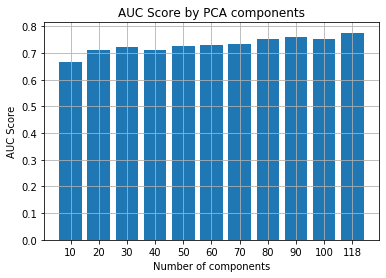

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)

n_components_list = [i*10 for i in range(1, 11)]
auc_list = []
### PCA cycle
for n_components in n_components_list:
    # 1. PCA
    print('Number of components: {}'.format(n_components))
    pca = PCA(n_components=n_components)
    tmp_Xtr = pca.fit_transform(X_train)
    tmp_Xte = pca.transform(X_test)
    # 2. Model fitting and prediction
    y_hat, y_hat_proba = evaluate(RandomForestClassifier(max_depth=25, n_jobs=1), tmp_Xtr, y_train, tmp_Xte, y_test)
    # 3. Display results
    _, _, auc_score = compute_roc(y_test, y_hat_proba, ax=0, plot=False)
    auc_list.append(auc_score)
    print('AUC Score: {}'.format(np.round(auc_score, 4)))
    print('-----------------------------')
    
### NO PCA
print('NO PCA')
# 1. Model fitting and prediction
y_hat, y_hat_proba = evaluate(RandomForestClassifier(max_depth=25, n_jobs=1), X_train, y_train, X_test, y_test)
# 2. Print results
_, _, auc_score = compute_roc(y_test, y_hat_proba, ax=0, plot=False)
auc_list.append(auc_score)
n_components_list.append(X.shape[1])
print('AUC Score: {}'.format(np.round(auc_score, 4)))
print('-----------------------------')

## RESULTS
key = [str(i) for i in n_components_list]
plt.bar(key, auc_list)
plt.xlabel('Number of components')
plt.ylabel('AUC Score')
plt.title('AUC Score by PCA components')
plt.grid()
plt.show()

### 2. Random Forest

Train metrics:	A: 0.995	F: 0.9831
Test metrics:	A: 0.8375	F: 0.3036
Precision: 0.8252
Recall: 0.186


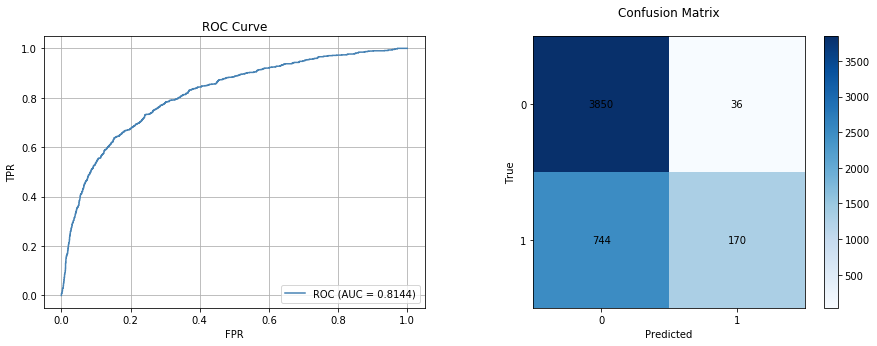

In [10]:
# ### 1.Perform GridSearch
# params = {'n_estimators': [20, 40, 80, 160],
#           'max_depth': [None, 8, 16, 32, 64],
#           'criterion': ('gini', 'enrtopy'), 
#           'class_weight': ['balanced', None]}     
# best_params = GridSearch(scaler.fit_transform(X), y, RandomForestClassifier(n_jobs=-1), params, 5, 'roc_auc')

# ### 2.Train Model with result from GridSearch
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)
# y_hat, y_hat_proba = evaluate(RandomForestClassifier(**best_params, n_jobs=-1), X_train, y_train, X_test, y_test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=42)
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)
y_hat, y_hat_proba = evaluate(RandomForestClassifier(n_estimators=160, max_depth=20, n_jobs=-1), X_train, y_train, X_test, y_test)

### 3.Display results
print('Precision: {}'.format(np.round(precision_score(y_test, y_hat), 4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_hat), 4)))
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_, _, auc_score, ax0 = compute_roc(y_test, y_hat_proba, ax=ax[0])
ax1 = plot_confusion_matrix(y_test, y_hat, log = True, ax=ax[1], fig=fig)
plt.show()

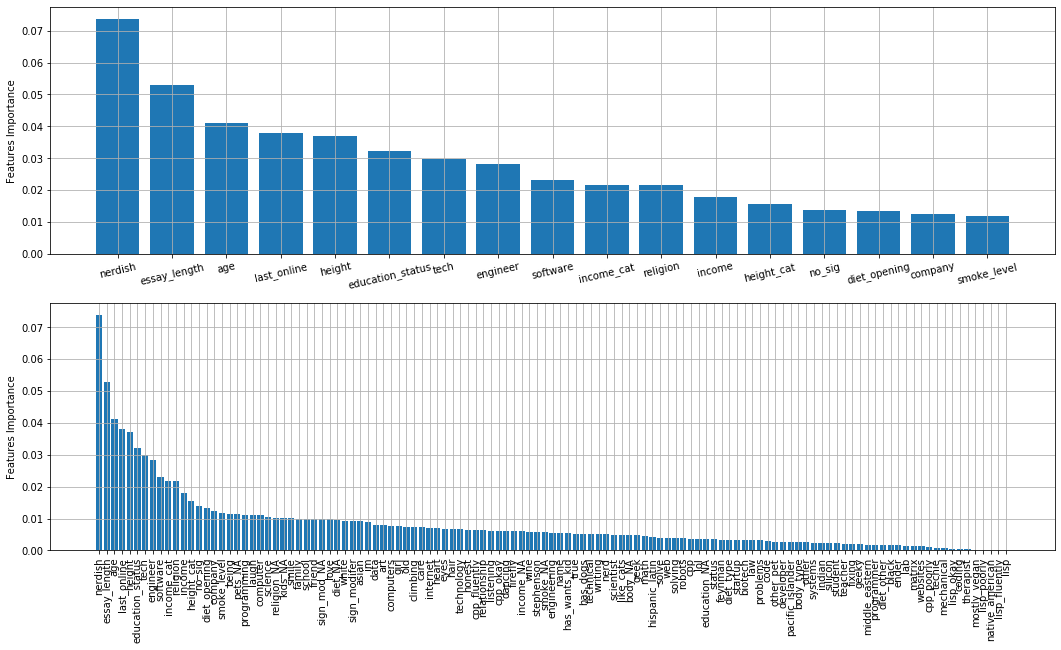

In [12]:
model = RandomForestClassifier(n_estimators=160, max_depth=20, n_jobs=-1)
model.fit(X_train, y_train)
fig, ax = plt.subplots(2, 1, figsize=(18, 10))
values = sorted([(i,j) for i, j in zip(model.feature_importances_, feat_col)], reverse=True)
ax[0].bar([i[1] for i in values][:17], [i[0] for i in values][:17])
ax[0].set_xticklabels([i[1] for i in values], rotation=13)
ax[0].grid()
ax[0].set_ylabel('Features Importance')
ax[1].bar([i[1] for i in values], [i[0] for i in values])
ax[1].set_xticklabels([i[1] for i in values], rotation=90)
ax[1].grid()
ax[1].set_ylabel('Features Importance')
plt.show()

Train metrics:	A: 1.0	F: 1.0
Test metrics:	A: 0.841	F: 0.3771
Precision: 0.7428
Recall: 0.2527


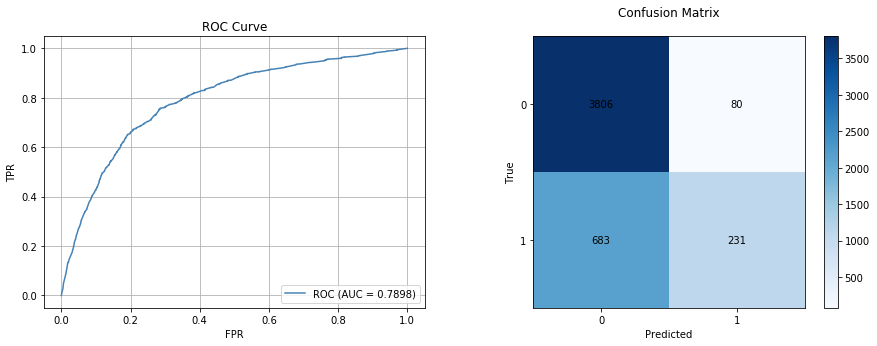

In [14]:
Xl, yl = df[[i[1] for i in values][:30]].values, df['Class'].values
X_trainl, X_testl, y_trainl, y_testl = train_test_split(Xl, yl, test_size=0.80, random_state=42)
X_trainl, X_testl = scaler.fit_transform(X_trainl), scaler.transform(X_testl)
y_hat, y_hat_proba = evaluate(RandomForestClassifier(n_estimators=160, max_depth=20, n_jobs=-1), 
                              X_trainl, y_trainl, X_testl, y_testl)

### 3.Display results
print('Precision: {}'.format(np.round(precision_score(y_test, y_hat), 4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_hat), 4)))
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_, _, auc_score, ax0 = compute_roc(y_test, y_hat_proba, ax=ax[0])
ax1 = plot_confusion_matrix(y_test, y_hat, log = True, ax=ax[1], fig=fig)
plt.show()

### 3. SVM

Train metrics:	A: 0.8926	F: 0.5875
Test metrics:	A: 0.8387	F: 0.3665
Precision: 0.7527
Recall: 0.2422


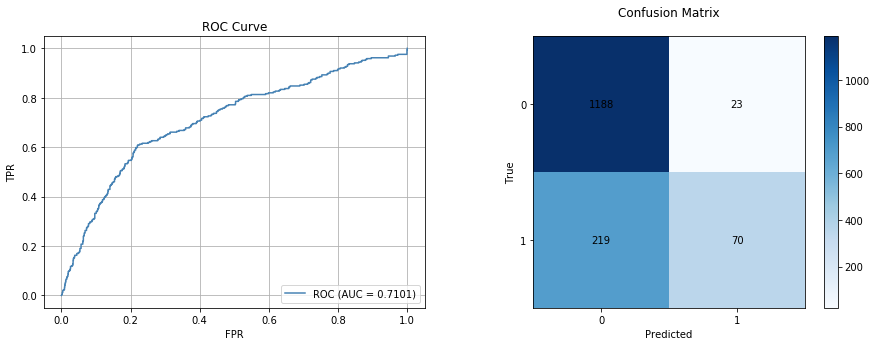

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)

# ### 1.Perform GridSearch
# params = {'C': [0.01, 0.1, 0.5, 1, 2],
#           'kernel': ('rbf', 'poly', 'sigmoid')}    
# best_params = GridSearch(scaler.fit_transform(X), y, SVC(), params, 5, 'roc_auc')

# ### 2.Train Model with result from GridSearch
# y_hat, y_hat_proba = evaluate(SVC(**best_params, probability=True), X_train, y_train, X_test, y_test)
y_hat, y_hat_proba = evaluate(SVC(probability=True), X_train, y_train, X_test, y_test)

### 3.Display results
print('Precision: {}'.format(np.round(precision_score(y_test, y_hat), 4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_hat), 4)))
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_, _, auc_score, ax0 = compute_roc(y_test, y_hat_proba, ax=ax[0])
ax1 = plot_confusion_matrix(y_test, y_hat, log = True, ax=ax[1], fig=fig)
plt.show()

### 4. MLP

Train metrics:	A: 0.927	F: 0.7583
Test metrics:	A: 0.8233	F: 0.3205
Precision: 0.6098
Recall: 0.2174


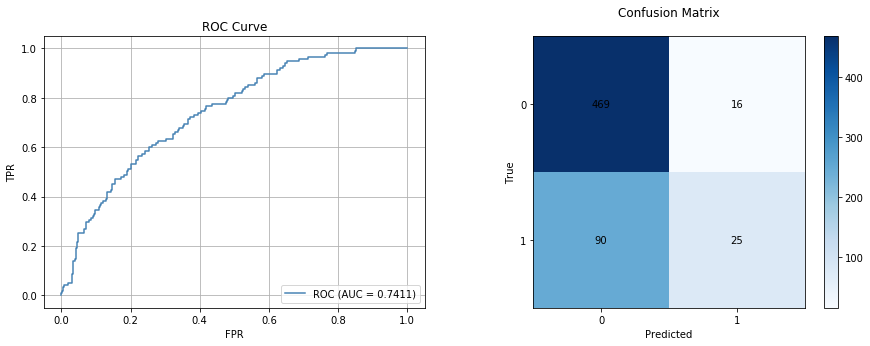

In [19]:
## 2.Train Model with result from GridSearch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)

model = MLPClassifier(solver='adam', hidden_layer_sizes=(256, 128, 32, 8), 
                      learning_rate='adaptive', early_stopping=True)
y_hat, y_hat_proba = evaluate(model, X_train, y_train, X_test, y_test)

### 3.Display results
print('Precision: {}'.format(np.round(precision_score(y_test, y_hat), 4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_hat), 4)))
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_, _, auc_score, ax0 = compute_roc(y_test, y_hat_proba, ax=ax[0])
ax1 = plot_confusion_matrix(y_test, y_hat, log = True, ax=ax[1], fig=fig)
plt.show()

In [20]:
### 1.Perform GridSearch
params = {'solver': ('lbfgs', 'sgd', 'adam'),
          'alpha': [0.0001, 0.001, 0.1],
          'learning_rate_init': [0.0001, 0.001, 0.01],
          'hidden_layer_sizes': [(256, 256, 128, 32, 8), (128, 128, 64, 16, 4), (256, 128, 32, 8), (128, 64, 32, 8)]}    
best_params = GridSearch(scaler.fit_transform(X), y, 
                         MLPClassifier(learning_rate='adaptive', early_stopping=True), 
                         params, 5, 'roc_auc')

### 2.Train Model with result from GridSearch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)
y_hat, y_hat_proba = evaluate(MLPClassifier(**best_params, learning_rate='adaptive', early_stopping=True), 
                              X_train, y_train, X_test, y_test)

### 3.Display results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_, _, auc_score, ax0 = compute_roc(y_test, y_hat_proba, ax=ax[0])
ax1 = plot_confusion_matrix(y_test, y_hat, log = True, ax=ax[1], fig=fig)
plt.show()

### 5. Naive Bayes

#### 5.1 Multinomial

Train metrics:	A: 0.8539	F: 0.5421
Test metrics:	A: 0.8333	F: 0.4819
Precision: 0.5962
Recall: 0.4043


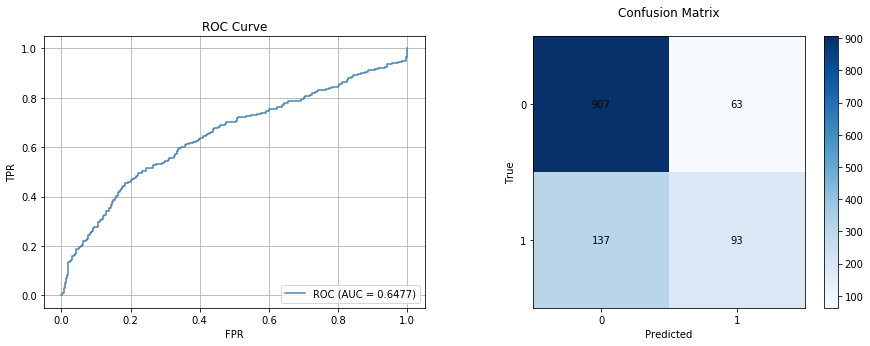

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)
y_hat, y_hat_proba = evaluate(MultinomialNB(), X_train, y_train, X_test, y_test)

### 3.Display results
print('Precision: {}'.format(np.round(precision_score(y_test, y_hat), 4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_hat), 4)))
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_, _, auc_score, ax0 = compute_roc(y_test, y_hat_proba, ax=ax[0])
ax1 = plot_confusion_matrix(y_test, y_hat, log = True, ax=ax[1], fig=fig)
plt.show()

#### 5.2 Bernoulli

Train metrics:	A: 0.8765	F: 0.5795
Test metrics:	A: 0.8335	F: 0.5241
Precision: 0.56
Recall: 0.4925


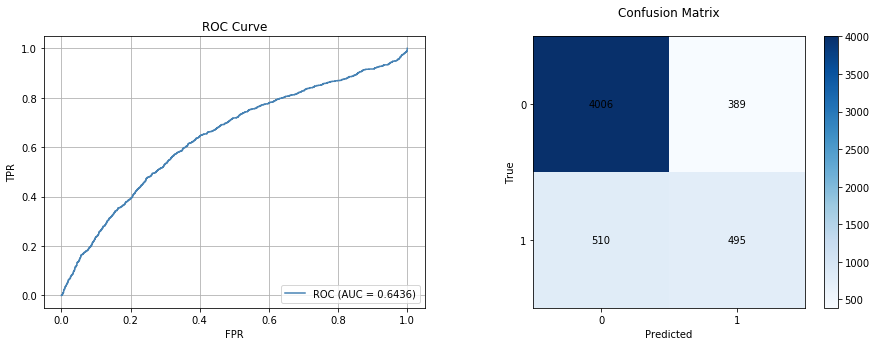

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=42)
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)
y_hat, y_hat_proba = evaluate(BernoulliNB(), X_train, y_train, X_test, y_test)

### 3.Display results
print('Precision: {}'.format(np.round(precision_score(y_test, y_hat), 4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_hat), 4)))
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_, _, auc_score, ax0 = compute_roc(y_test, y_hat_proba, ax=ax[0])
ax1 = plot_confusion_matrix(y_test, y_hat, log = True, ax=ax[1], fig=fig)
plt.show()

#### 5.3 Categorical

Train metrics:	A: 0.8558	F: 0.5459
Test metrics:	A: 0.835	F: 0.5308
Precision: 0.5753
Recall: 0.4927


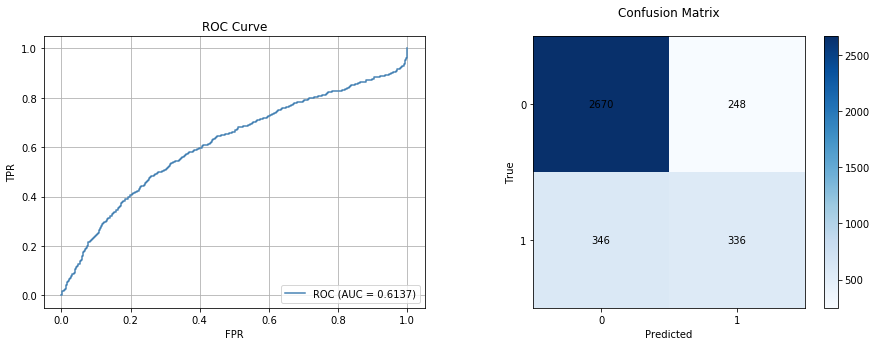

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60, random_state=42)
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)
y_hat, y_hat_proba = evaluate(CategoricalNB(), X_train, y_train, X_test, y_test)

### 3.Display results
print('Precision: {}'.format(np.round(precision_score(y_test, y_hat), 4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_hat), 4)))
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_, _, auc_score, ax0 = compute_roc(y_test, y_hat_proba, ax=ax[0])
ax1 = plot_confusion_matrix(y_test, y_hat, log = True, ax=ax[1], fig=fig)
plt.show()

### 6. XGBoost

Precision: 0.6565
Recall: 0.3475


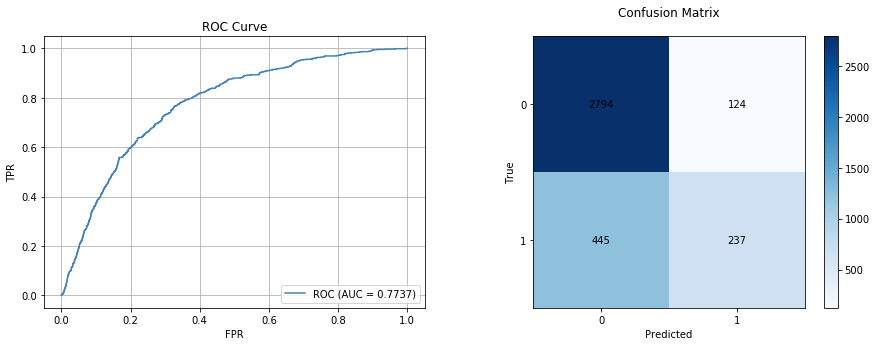

In [103]:
from xgboost import XGBClassifier
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60, random_state=42)
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

param = {'booster': 'gbtree',
         'eta': 0.3, 
         'max_depth': 3,  
         'objective': 'multi:softprob',  
         'num_class': 2} 

steps = 20  # The number of training iterations

model = xgb.train(param, D_train, steps, verbose_eval=1)
y_hat_proba = model.predict(D_test)
y_hat = np.asarray([np.argmax(line) for line in y_hat_proba])

### 3.Display results
print('Precision: {}'.format(np.round(precision_score(y_test, y_hat), 4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_hat), 4)))
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_, _, auc_score, ax0 = compute_roc(y_test, np.min(y_hat_proba, axis=1), ax=ax[0])
ax1 = plot_confusion_matrix(y_test, y_hat, log = True, ax=ax[1], fig=fig)
plt.show()

In [89]:
clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.15, 0.30] ,
     "max_depth"        : [ 3, 5, 8, 15],
     "min_child_weight" : [ 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.2, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="roc_auc",
                    cv=2, verbose=2)

grid.fit(X, y)
print('best parameters:\n{}'.format(grid.best_params_))

Fitting 2 folds for each of 324 candidates, totalling 648 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   31.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 12.5min
[Parallel(n_jobs=4)]: Done 648 out of 648 | elapsed: 12.9min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'eta': [0.05, 0.15, 0.3], 'gamma': [0.0, 0.2, 0.4],
                         'max_depth': [3,

Precision: 0.6738
Recall: 0.3695


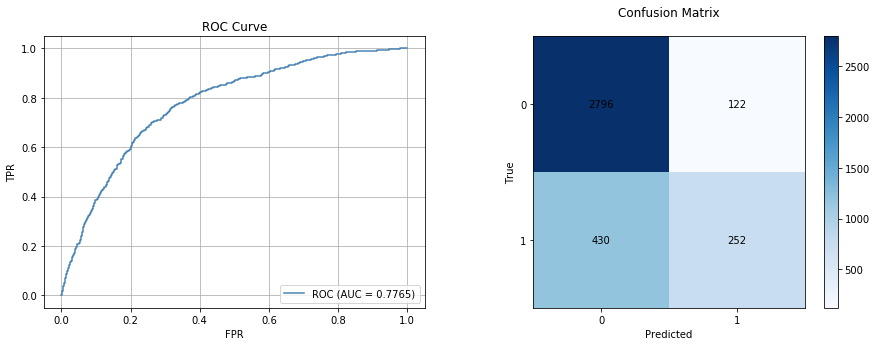

In [96]:
clf = xgb.XGBClassifier(**grid.best_params_)
clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='logloss',
        verbose=False)

y_hat_proba = clf.predict_proba(X_test)

y_hat = np.asarray([np.argmax(line) for line in y_hat_proba])

### 3.Display results
print('Precision: {}'.format(np.round(precision_score(y_test, y_hat), 4)))
print('Recall: {}'.format(np.round(recall_score(y_test, y_hat), 4)))
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_, _, auc_score, ax0 = compute_roc(y_test, np.min(y_hat_proba, axis=1), ax=ax[0])
ax1 = plot_confusion_matrix(y_test, y_hat, log = True, ax=ax[1], fig=fig)
plt.show()

### 7. PyTorch Approach

In [24]:
class FFN(nn.Module):
    def __init__(self, input_size = 108, layers_dim = [256, 256, 128, 32, 8], dropout=0.1):
        super(FFN, self).__init__()
        self.layers_dim = layers_dim
        self.layers_dim.insert(0, input_size)
        self.dropout_prob = dropout
        self.net = self.build_network()

    def build_network(self):
        layers = []
        for n in range(len(self.layers_dim)-1):
            layers.append(nn.Linear(self.layers_dim[n], self.layers_dim[n+1]))
            layers.append(nn.SELU())
            layers.append(nn.Dropout(p=self.dropout_prob))
        layers.append(nn.Linear(self.layers_dim[-1], 2))
#         layers.append(nn.Sigmoid())
#        layers.append(nn.Softmax(dim=1))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)
    
    def __str__(self):
        return self.net.__str__()
    
from torch.autograd import Variable

    
def train():
    ### 1. Enable train Mode
    NN.train()
    ### 2. Init batch loss list
    tmp_loss = []
    ### 3. Training cycle
    for batch in range(X_train.shape[0]//batch_size):
        optimizer.zero_grad()
        # 3.a Get input and label of batch 
        x = X_train[batch*batch_size:(batch+1)*batch_size, :].float()
        label = y_train[batch*batch_size:(batch+1)*batch_size].float()
        # 3.b Get output
        out = NN(x).view(-1, 2)
        # 3.c Compute Loss, save it
        loss = loss_fn(out.float(),label.long())
        tmp_loss.append(loss.data.item())
        # 3.d BackPropagation
        loss.backward()
        optimizer.step()
    return np.round(np.mean(tmp_loss), 4)

In [25]:
device = torch.device('cuda')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
### To Tensor
X_train, X_test = torch.tensor(scaler.fit_transform(X_train)), torch.tensor(scaler.transform(X_test))
y_train, y_test = torch.tensor(y_train), torch.tensor(y_test)
### TO Device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
print('Shape of train and test: {}, {}'.format(X_train.shape, X_test.shape))

Shape of train and test: torch.Size([5099, 119]), torch.Size([900, 119])


In [28]:
params = {'input_size': 119, 
          'layers_dim': [256, 128, 64, 8],
          'dropout': 0.3}
NN = FFN(**params)
optimizer = optim.Adam(NN.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
NN = NN.to(device)
print(NN)

Sequential(
  (0): Linear(in_features=119, out_features=256, bias=True)
  (1): SELU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): SELU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): SELU()
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=64, out_features=8, bias=True)
  (10): SELU()
  (11): Dropout(p=0.3, inplace=False)
  (12): Linear(in_features=8, out_features=2, bias=True)
)


In [29]:
### 1. Set training parameters
batch_size = 300
epochs = 110
verbose = 10

### 2. Set list of losses
training_loss, validation_loss = [], []
accuracy, f1, balanced_accuracy = [], [], []

### 3. Training cycle
for ep in range(epochs):
    ### 3.1 Training 
    loss = train()
    
    training_loss.append(loss)
    ### 3.2 Validation mode
    with torch.no_grad():
        # 3.2.a Validation Mode Enabled
        NN.eval()
        # 3.2.b Get out and loss 
        out = NN(X_test.float()).view(-1, 2)
        loss = loss_fn(out.float(),y_test.long())
        
    y_hat = np.argmax(out.detach().cpu().numpy(), axis=1)
    y_true = y_test.cpu().numpy()
    validation_loss.append(loss.data.item())
    
    ### 3.3 Save metrics
    accuracy.append(accuracy_score(y_hat, y_true))
    balanced_accuracy.append(balanced_accuracy_score(y_hat, y_true))
    f1.append(f1_score(y_hat, y_true))
    
    ### Display results
    if ep == 0:
        mean_acc = np.round(accuracy[0], 4)
        mean_bal_acc = np.round(balanced_accuracy[0], 4)
        mean_f1 = np.round(f1[0], 4)
        
        mean_train = np.round(training_loss[0], 4)
        mean_valid = np.round(validation_loss[0], 4)
        print('Epoch: {}\ttrain_loss: {}\tval_loss: {}\tA: {}\tA(balanced): {}\tF1: {}'.format(ep+1, mean_train, mean_valid,
                                                                                               mean_acc, mean_bal_acc, mean_f1))
    if (ep+1)%verbose==0:
        mean_acc = np.round(np.mean(accuracy[-10:]), 4)
        mean_bal_acc = np.round(np.mean(balanced_accuracy[-10:]), 4)
        mean_f1 = np.round(np.mean(f1[-10:]), 4)
        
        mean_train = np.round(np.mean(training_loss[-10:]), 4)
        mean_valid = np.round(np.mean(validation_loss[-10:]), 4)
        
        print('Epoch: {}\ttrain_loss: {}\tval_loss: {}\tA: {}\tA(balanced): {}\tF1: {}'.format(ep+1, mean_train, mean_valid,
                                                                                               mean_acc, mean_bal_acc, mean_f1))

Epoch: 1	train_loss: 0.7504	val_loss: 0.63	A: 0.7956	A(balanced): 0.5257	F1: 0.0612


C:\Users\fgrim\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Epoch: 10	train_loss: 0.5192	val_loss: 0.4811	A: 0.8117	A(balanced): 0.8138	F1: 0.0396
Epoch: 20	train_loss: 0.3909	val_loss: 0.4073	A: 0.8287	A(balanced): 0.7476	F1: 0.3259
Epoch: 30	train_loss: 0.37	val_loss: 0.3995	A: 0.838	A(balanced): 0.7603	F1: 0.4082
Epoch: 40	train_loss: 0.3576	val_loss: 0.3966	A: 0.8391	A(balanced): 0.7628	F1: 0.4157
Epoch: 50	train_loss: 0.3521	val_loss: 0.3946	A: 0.8373	A(balanced): 0.7568	F1: 0.4101
Epoch: 60	train_loss: 0.3484	val_loss: 0.3942	A: 0.8353	A(balanced): 0.7491	F1: 0.4071
Epoch: 70	train_loss: 0.3468	val_loss: 0.3928	A: 0.8349	A(balanced): 0.7477	F1: 0.405
Epoch: 80	train_loss: 0.3417	val_loss: 0.3925	A: 0.8359	A(balanced): 0.7485	F1: 0.4173
Epoch: 90	train_loss: 0.3424	val_loss: 0.3913	A: 0.8351	A(balanced): 0.7451	F1: 0.4184
Epoch: 100	train_loss: 0.3361	val_loss: 0.3917	A: 0.835	A(balanced): 0.7444	F1: 0.4196
Epoch: 110	train_loss: 0.336	val_loss: 0.3914	A: 0.8339	A(balanced): 0.7416	F1: 0.4139


Precision: 0.7611
Recall: 0.4448


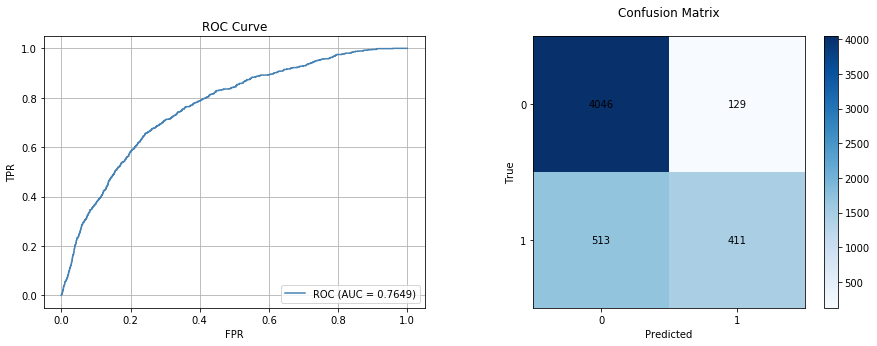

In [30]:
out = nn.Softmax(dim=1)(NN(X_train.float())).detach().cpu().numpy()
#out = NN(X_test.float()).detach().cpu().numpy()
y_hat, y_hat_proba = np.argmax(out, axis=1), np.min(out, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_, _, auc_score, ax0 = compute_roc(y_train.cpu(), y_hat_proba, ax=ax[0])
ax1 = plot_confusion_matrix(y_train.cpu(), y_hat, log = True, ax=ax[1], fig=fig)
print('Precision: {}'.format(np.round(precision_score(y_train.cpu(), y_hat), 4)))
print('Recall: {}'.format(np.round(recall_score(y_train.cpu(), y_hat), 4)))
plt.show()

Precision: 0.642
Recall: 0.3041


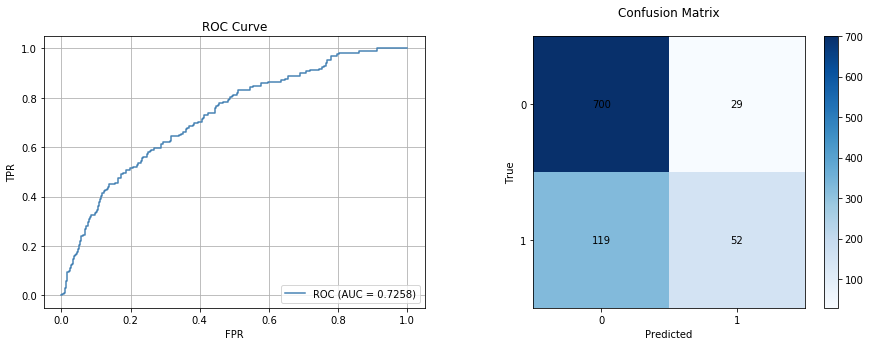

In [31]:
out = nn.Softmax(dim=1)(NN(X_test.float())).detach().cpu().numpy()
#out = NN(X_test.float()).detach().cpu().numpy()
y_hat, y_hat_proba = np.argmax(out, axis=1), np.min(out, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_, _, auc_score, ax0 = compute_roc(y_test.cpu(), y_hat_proba, ax=ax[0])
ax1 = plot_confusion_matrix(y_test.cpu(), y_hat, log = True, ax=ax[1], fig=fig)
print('Precision: {}'.format(np.round(precision_score(y_test.cpu(), y_hat), 4)))
print('Recall: {}'.format(np.round(recall_score(y_test.cpu(), y_hat), 4)))
plt.show()

In [6]:
import tensorflow as tf

def roc_auc_score(y_pred, y_true):
    """ ROC AUC Score.
    Approximates the Area Under Curve score, using approximation based on
    the Wilcoxon-Mann-Whitney U statistic.
    Yan, L., Dodier, R., Mozer, M. C., & Wolniewicz, R. (2003).
    Optimizing Classifier Performance via an Approximation to the Wilcoxon-Mann-Whitney Statistic.
    Measures overall performance for a full range of threshold levels.
    Arguments:
        y_pred: `Tensor`. Predicted values.
        y_true: `Tensor` . Targets (labels), a probability distribution.
    """
    with tf.name_scope("RocAucScore"):

        pos = tf.boolean_maskMy(y_pred, tf.cast(y_true, tf.bool))
        neg = tf.boolean_mask(y_pred, ~tf.cast(y_true, tf.bool))

        pos = tf.expand_dims(pos, 0)
        neg = tf.expand_dims(neg, 1)

        # original paper suggests performance is robust to exact parameter choice
        gamma = 0.2
        p     = 3

        difference = tf.zeros_like(pos * neg) + pos - neg - gamma

        masked = tf.boolean_mask(difference, difference < 0.0)

        return tf.reduce_sum(tf.pow(-masked, p))

In [42]:
class MyLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_pred, y_true):
        pos = y_pred[y_true == 1].view(1, -1)
        neg = y_pred[y_true == 0].view(-1, 1)

        gamma = 0.2
        p     = 5

        difference = torch.zeros_like(pos * neg) + pos - neg - gamma
        mask = torch.mean(torch.pow(-difference[difference < 0], p))
        return mask        
                         
loss_fn = MyLoss()
params = {'input_size': 119, 
          'layers_dim': [256, 128, 64, 8],
          'dropout': 0.3}
NN = FFN(**params)
optimizer = optim.Adam(NN.parameters(), lr=0.001)
NN = NN.to(device)
print(NN)

Sequential(
  (0): Linear(in_features=119, out_features=256, bias=True)
  (1): SELU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): SELU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): SELU()
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=64, out_features=8, bias=True)
  (10): SELU()
  (11): Dropout(p=0.3, inplace=False)
  (12): Linear(in_features=8, out_features=2, bias=True)
)


In [ ]:
### 1. Set training parameters
batch_size = 200
epochs = 300
verbose = 10

outs = []
### 2. Set list of losses
training_loss, validation_loss = [], []
accuracy, f1, balanced_accuracy = [], [], []

### 3. Training cycle
for ep in range(epochs):
    ### 3.1 Training 
    loss = train()
    
    training_loss.append(loss)
    ### 3.2 Validation mode
    with torch.no_grad():
        # 3.2.a Validation Mode Enabled
        NN.eval()
        # 3.2.b Get out and loss 
        out = NN(X_test.float()).view(-1, 2)
        outs.append(out)
        loss = loss_fn(out.float(),y_test.long())
    #break  
    y_hat = np.argmax(out.detach().cpu().numpy(), axis=1)
    y_true = y_test.cpu().numpy()
    validation_loss.append(loss.data.item())
    
    
    ### 3.3 Save metrics
    accuracy.append(accuracy_score(y_hat, y_true))
    balanced_accuracy.append(balanced_accuracy_score(y_hat, y_true))
    f1.append(f1_score(y_hat, y_true))
    
    ### Display results
    if ep == 0:
        mean_acc = np.round(accuracy[0], 4)
        mean_bal_acc = np.round(balanced_accuracy[0], 4)
        mean_f1 = np.round(f1[0], 4)
        
        mean_train = np.round(training_loss[0]*100,  4)
        mean_valid = np.round(validation_loss[0]*100, 4)
        print('Epoch: {}\ttrain_loss: {}\tval_loss: {}\tA: {}\tA(balanced): {}\tF1: {}'.format(ep+1, mean_train, mean_valid,
                                                                                               mean_acc, mean_bal_acc, mean_f1))
    if (ep+1)%verbose==0:
        mean_acc = np.round(np.mean(accuracy[-10:]), 4)
        mean_bal_acc = np.round(np.mean(balanced_accuracy[-10:]), 4)
        mean_f1 = np.round(np.mean(f1[-10:]), 4)
        
        mean_train = np.round(np.mean(training_loss[-10:])*100, 4)
        mean_valid = np.round(np.mean(validation_loss[-10:])*100, 4)
        
        print('Epoch: {}\ttrain_loss: {}\tval_loss: {}\tA: {}\tA(balanced): {}\tF1: {}'.format(ep+1, mean_train, mean_valid,
                                                                                               mean_acc, mean_bal_acc, mean_f1))

In [ ]:
out = nn.Softmax(dim=1)(NN(X_train.float())).detach().cpu().numpy()
#out = NN(X_test.float()).detach().cpu().numpy()
y_hat, y_hat_proba = np.argmax(out, axis=1), np.min(out, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_, _, auc_score, ax0 = compute_roc(y_train.cpu(), y_hat_proba, ax=ax[0])
ax1 = plot_confusion_matrix(y_train.cpu(), y_hat, log = True, ax=ax[1], fig=fig)
print('Precision: {}'.format(np.round(precision_score(y_train.cpu(), y_hat), 4)))
print('Recall: {}'.format(np.round(recall_score(y_train.cpu(), y_hat), 4)))
plt.show()

In [ ]:
out = nn.Softmax(dim=1)(NN(X_test.float())).detach().cpu().numpy()
#out = NN(X_test.float()).detach().cpu().numpy()
y_hat, y_hat_proba = np.argmax(out, axis=1), np.min(out, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
_, _, auc_score, ax0 = compute_roc(y_test.cpu(), y_hat_proba, ax=ax[0])
ax1 = plot_confusion_matrix(y_test.cpu(), y_hat, log = True, ax=ax[1], fig=fig)
print('Precision: {}'.format(np.round(precision_score(y_test.cpu(), y_hat), 4)))
print('Recall: {}'.format(np.round(recall_score(y_test.cpu(), y_hat), 4)))
plt.show()